In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import shap

In [23]:
day_data = pd.read_csv("day_data.csv")

In [24]:
day_data = day_data.rename(columns={'date':'ds'})
day_data['ds'] = pd.to_datetime(day_data['ds'], format="%Y-%m-%d")

day_data

,ds,holiday,moon,arrest,num_crimes,wd,wPC1,wPC2,wPC3,wPC4,wPC5,wPC6,wPC7,wPC8,wPC9,wPC10
0,2010-01-01,New Year's Day,0.0,0.216216,74,Friday,5.288267,-3.436754,-1.934383,-1.600636,-0.696136,-0.241663,1.004215,-0.902615,0.690424,0.769404
1,2010-01-02,NaN,0.0,0.431373,51,Saturday,5.641923,-3.922099,-1.749891,0.514432,-0.514421,-0.576854,0.301494,-0.932726,0.739275,0.646302
2,2010-01-03,NaN,0.0,0.340909,44,Sunday,5.507165,-3.413418,-1.835230,0.129064,-0.829287,-0.590793,0.545550,-0.652679,0.542035,0.667098
3,2010-01-04,NaN,0.0,0.403846,52,Monday,5.541065,-2.051329,-1.750209,-0.447364,-1.676369,-0.456364,1.196762,-0.052274,0.074147,0.563735
4,2010-01-05,NaN,0.0,0.557692,52,Tuesday,4.669759,-2.226177,-2.045199,-1.743264,-1.387959,-0.503360,1.536731,-0.253174,0.040207,0.699972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5163,2024-02-20,NaN,0.0,0.404762,42,Tuesday,0.602161,-1.725383,2.954238,0.672353,0.473708,0.116843,-0.981618,-0.549289,0.468765,0.292148
5164,2024-02-21,NaN,0.0,0.257143,35,Wednesday,-0.040959,-0.297407,3.211835,0.665019,-0.421476,0.405655,0.196629,0.443601,0.042665,0.167132
5165,2024-02-22,NaN,0.0,0.484848,33,Thursday,-0.364136,-0.396566,2.821366,-1.084647,-0.066928,0.293640,-0.583374,0.447769,-0.638291,0.414484
5166,2024-02-23,NaN,0.0,0.321429,28,Friday,2.019623,1.029959,2.236592,2.259861,1.268149,0.263113,1.007122,-0.534049,-0.056450,0.150931


In [4]:
day_data['holiday'] = day_data['holiday'].apply(lambda x: 0 if pd.isna(x) else 1)

In [25]:
holidays = day_data[['ds', 'holiday']]
holidays['lower_window'] = -7
holidays['upper_window'] = 7
holidays['ds'] = pd.to_datetime(holidays['ds'], format="%Y-%m-%d")
calendar = holidays
calendar = calendar[~calendar['holiday'].isnull()]

/var/folders/rn/h4vfsnp1323835fz9_ftzqmr0000gn/T/ipykernel_78481/3900610980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays['lower_window'] = -7
/var/folders/rn/h4vfsnp1323835fz9_ftzqmr0000gn/T/ipykernel_78481/3900610980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays['upper_window'] = 7
/var/folders/rn/h4vfsnp1323835fz9_ftzqmr0000gn/T/ipykernel_78481/3900610980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [26]:
start_date = day_data['ds'].min()
end_date = '2024-01-31'
all_dates = pd.DataFrame(
    data=pd.date_range(start_date, end_date, freq='d'),
    columns=['ds']
)
all_dates['ds'] = pd.to_datetime(all_dates['ds'], format="%Y-%m-%d")

In [27]:
#day_data['holiday'] = day_data['holiday'].notnull().astype(int)
day_data['date'] = pd.to_datetime(day_data['date'])
Y = day_data['num_crimes']
X = day_data.drop(columns=['num_crimes', 'date'])

X = pd.get_dummies(X, prefix='wd')


KeyError: 'date'

In [45]:
all_dates.dtypes

ds    datetime64[ns]
dtype: object

In [46]:
day_data.dtypes

ds            datetime64[ns]
holiday               object
moon                 float64
arrest               float64
num_crimes             int64
wd                    object
wPC1                 float64
wPC2                 float64
wPC3                 float64
wPC4                 float64
wPC5                 float64
wPC6                 float64
wPC7                 float64
wPC8                 float64
wPC9                 float64
wPC10                float64
dtype: object

In [28]:
day_data = day_data.drop(columns=['holiday'])
regressor_columns = ['moon', 'arrest', 'wd']
output_data = pd.merge(
    all_dates[all_dates['ds'] >= day_data['ds'].min()], 
    day_data, 
    how='left', 
    on=['ds'])
output_data.sort_values(
    by=['ds'], 
    ascending=True, 
    inplace=True, 
    ignore_index=True)

input_data = day_data.rename(columns={'num_crimes': 'y'})
enc = OneHotEncoder(drop='first')
wd_enc = enc.fit_transform(input_data[['wd']])
wd_enc = wd_enc.toarray()
wds = enc.get_feature_names_out(['wd'])
wd_enc = pd.DataFrame(wd_enc, columns=wds)
input_data = pd.concat([input_data, wd_enc], axis=1)
input_data = input_data.drop(columns=['wd'])
input_data = input_data[input_data['ds'] < '2024-01-01']

output_data = output_data.rename(columns={'num_crimes': 'y'})
wd_enc = enc.fit_transform(output_data[['wd']])
wds = enc.get_feature_names_out(['wd'])
wd_enc = wd_enc.toarray()
wd_enc = pd.DataFrame(wd_enc, columns=wds)
output_data = pd.concat([output_data, wd_enc], axis=1)
output_data = output_data.drop(columns=['wd'])

In [29]:
output_data

,ds,moon,arrest,y,wPC1,wPC2,wPC3,wPC4,wPC5,wPC6,wPC7,wPC8,wPC9,wPC10,wd_Monday,wd_Saturday,wd_Sunday,wd_Thursday,wd_Tuesday,wd_Wednesday
0,2010-01-01,0.0,0.216216,74,5.288267,-3.436754,-1.934383,-1.600636,-0.696136,-0.241663,1.004215,-0.902615,0.690424,0.769404,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-02,0.0,0.431373,51,5.641923,-3.922099,-1.749891,0.514432,-0.514421,-0.576854,0.301494,-0.932726,0.739275,0.646302,0.0,1.0,0.0,0.0,0.0,0.0
2,2010-01-03,0.0,0.340909,44,5.507165,-3.413418,-1.835230,0.129064,-0.829287,-0.590793,0.545550,-0.652679,0.542035,0.667098,0.0,0.0,1.0,0.0,0.0,0.0
3,2010-01-04,0.0,0.403846,52,5.541065,-2.051329,-1.750209,-0.447364,-1.676369,-0.456364,1.196762,-0.052274,0.074147,0.563735,1.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-05,0.0,0.557692,52,4.669759,-2.226177,-2.045199,-1.743264,-1.387959,-0.503360,1.536731,-0.253174,0.040207,0.699972,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5139,2024-01-27,0.0,0.269231,26,4.113588,3.290762,1.304504,-2.830604,2.545109,-0.420146,-0.124049,0.207530,-2.340912,-0.208547,0.0,1.0,0.0,0.0,0.0,0.0
5140,2024-01-28,0.0,0.233333,30,4.063519,2.528423,2.007294,0.209619,1.146148,-0.607883,1.419367,-1.196025,-1.257515,-0.571011,0.0,0.0,1.0,0.0,0.0,0.0
5141,2024-01-29,0.0,0.195122,41,2.671958,0.073699,2.491474,-0.488458,-0.445928,-0.508123,0.091150,0.328549,-0.012693,0.378546,1.0,0.0,0.0,0.0,0.0,0.0
5142,2024-01-30,0.0,0.324324,37,2.897211,2.368822,2.299580,-0.448229,-0.859300,-0.546589,0.936911,-0.594161,-0.896787,-0.039709,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
input_data = input_data.drop(columns=['ds'])

In [7]:
input_data['year'] = input_data['ds'].dt.year
input_data['month'] = input_data['ds'].dt.month
input_data['day'] = input_data['ds'].dt.day


y_real = output_data[output_data['ds'] > '2023-12-31']['y']
output_data['year'] = output_data['ds'].dt.year
output_data['month'] = output_data['ds'].dt.month
output_data['day'] = output_data['ds'].dt.day

input_data = input_data.drop(columns=['ds'])


In [36]:
output_data = output_data.drop(columns=['ds'])
output_data.dtypes

moon            float64
arrest          float64
y                 int64
wPC1            float64
wPC2            float64
wPC3            float64
wPC4            float64
wPC5            float64
wPC6            float64
wPC7            float64
wPC8            float64
wPC9            float64
wPC10           float64
wd_Monday       float64
wd_Saturday     float64
wd_Sunday       float64
wd_Thursday     float64
wd_Tuesday      float64
wd_Wednesday    float64
dtype: object

In [34]:
y = input_data['y']
X = input_data.drop(columns=['y'])

In [37]:
pre_predictions = output_data.drop(columns=['y'])

In [38]:
lasso = LassoCV()
lasso.fit(X, y)

forecast = lasso.predict(pre_predictions)
my_preds = forecast[-31:]
#filter_forecast = forecast[(forecast['year'] > 2023) & (forecast['month'] > 12) & (forecast['day'] > 31)]
#preds = filter_forecast['yhat']


mse =mean_squared_error(y_true=y_real, y_pred=my_preds)
coef = lasso.coef_
coef
np.sqrt(mse)

6.996491916056154

In [14]:
len(forecast)

5144

In [39]:
support_vector_regressor = SVR(kernel="linear")
support_vector_regressor.fit(X, y)

y_pred_svr = support_vector_regressor.predict(pre_predictions)
mse = mean_squared_error(y_real, y_pred_svr[-31:])
np.sqrt(mse)


6.75865445127467

In [ ]:
shap.initjs()

In [40]:
explainer = shap.Explainer(lasso.predict, pre_predictions)
shap_values = explainer(X)


PermutationExplainer explainer: 5114it [01:38, 47.28it/s]                          


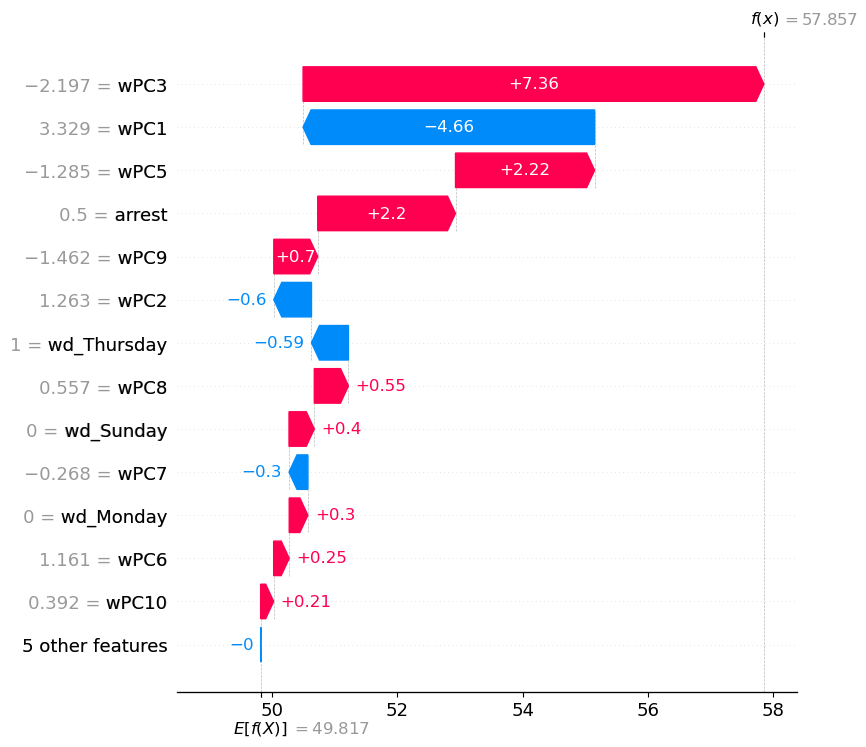

In [41]:
shap.plots.waterfall(shap_values[20], max_display=14)

In [43]:
explainer = shap.Explainer(support_vector_regressor.predict, pre_predictions)
shap_values = explainer(X.head(100))


PermutationExplainer explainer: 101it [05:02,  3.12s/it]                         


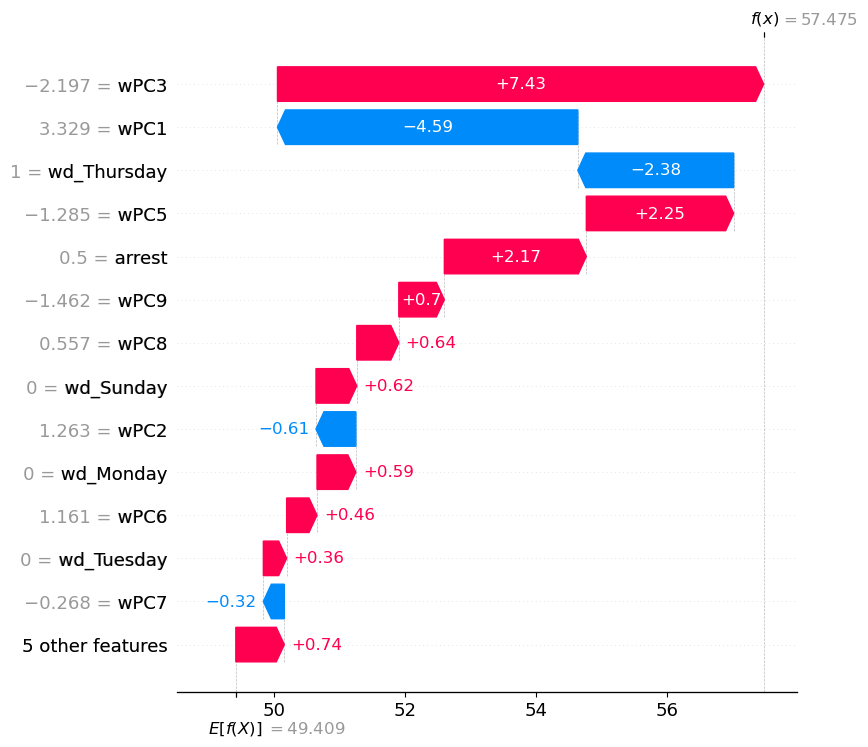

In [44]:
shap.plots.waterfall(shap_values[20], max_display=14)